In [1]:
import numpy
import os
import pandas as pd
import tables  # This will fail if you don't have 'pytables' installed to read the cache file

import dask.dataframe as dd

import sklearn.ensemble

In [2]:
DATA_DIR = '../../data'
RAW_DATA_DIR = DATA_DIR + '/raw'
LOOKUPS = RAW_DATA_DIR + "/Lookups"
TRANSACT = RAW_DATA_DIR + "/Transactions"

SUBSET_FILE = DATA_DIR + '/' + 'subset.hdf'
THINNED_FILE = DATA_DIR + '/' + 'thinned.hdf'

In [3]:
files = os.listdir(TRANSACT)

In [4]:
stores = pd.read_csv(LOOKUPS + '/stores.txt', sep='\t')
drugs = pd.read_csv(LOOKUPS + '/Drug_LookUp.txt', sep='\t')
illness = pd.read_csv(LOOKUPS + '/ChronicIllness_LookUp.txt', sep='\t')
patients = pd.read_csv(LOOKUPS + '/patients.txt', sep='\t')
atc = pd.read_csv(LOOKUPS + '/ATC_LookUp.txt', sep='\t')

In [5]:
t1 = illness.merge(drugs, on='MasterProductID', how='outer')

In [6]:
def get_subset(frac=0.1):
    samples = []
    for file in files:
        df = pd.read_csv(TRANSACT + '/' + file, sep='\t')
        sample = df.sample(frac=frac)
        samples.append(sample)

    return pd.concat(samples)

In [7]:
def expand_subset(subset):
    subset = subset.merge(t1, left_on='Drug_ID', right_on='MasterProductID', suffixes=('_illness', '_drug'), how='outer')    
    subset = subset.merge(patients, on='Patient_ID', how='outer')
    subset['target'] = subset['ChronicIllness'] == 'Diabetes'
    
    return subset

In [8]:
def get_subset_cached():
    
    if os.path.exists(SUBSET_FILE):
        print("Using cached file")
        return pd.read_hdf(SUBSET_FILE, '/data')
    
    subset = get_subset()
    subset = expand_subset(subset)
    
    subset.to_hdf(SUBSET_FILE, '/data')
    return subset

In [9]:
def get_thinned_cached(subset=None):
    
    if os.path.exists(THINNED_FILE):
        return pd.read_hdf(THINNED_FILE, '/data')
    
    if subset is None:
        subset = get_subset_cached()
        
    relevant = [
        'Patient_ID',
        'Store_ID',
        'Prescriber_ID',
        'Drug_ID',
        'Prescription_Week',
        'Dispense_Week',
        'Drug_Code',
        'NHS_Code',
        'PatientPrice_Amt', 
        'WholeSalePrice_Amt',
        'GovernmentReclaim_Amt', 
        'StreamlinedApproval_Code', 
        'ChemistListPrice',
        'gender', 
        'year_of_birth', 
        'postcode', 
        'target'                
    ]
    
    thinned = subset[relevant]
    
    thinned.to_hdf(THINNED_FILE, '/data')
    return thinned

In [10]:
#subset = get_subset_cached()

In [11]:
#subset.head()

In [12]:
thinned = get_thinned_cached()
train_fields = ['year_of_birth', 'postcode', 'Store_ID', 'gender', 'PatientPrice_Amt', 'target']
train = thinned[train_fields].copy()
train['gender'] = train['gender'] == 'M'

In [13]:
valid_ratio = len(train.dropna()) / len(train)
print(str(valid_ratio))

if valid_ratio > .95:
    train = train.dropna()

0.9947759782137479


In [14]:
def fixify(df):
    
    for col in df.columns:
        df[col] = df[col].astype(numpy.float32)
        
    for col in df.columns:
        try:
            sklearn.utils.assert_all_finite(df[col])
        except:
            print("Problem is in %s" % str(col))
            raise

In [15]:
fixify(train)

In [16]:
rf = sklearn.ensemble.RandomForestRegressor(30)

In [17]:
rf.fit(train[train_fields], train['target'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [35]:
rf.score(train[train_fields], train['target'])  # 1 is perfect

1.0

In [19]:
base_rate = sum(train['target']) / len(train)
print(str(base_rate))

0.0606390320907


In [20]:
prediction = rf.predict(train[train_fields])
truth = train['target']

In [21]:
indexes = list(train.index)

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

/Users/tjl/anaconda/envs/dthon/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


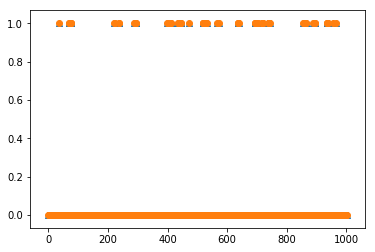

In [31]:
plt.scatter(indexes[:1000], prediction[:1000], marker='^')
plt.scatter(indexes[:1000], truth[:1000], marker='o')
plt.show()

In [32]:
deltas = truth - prediction